# Lending Club Case Study
###### Group facilitator : Lakshya Daulani
###### Group member : Shijina Padmanabhan

### Importing Libraries and loading data

In [2]:
# !pip install abc-analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import datetime as dt
from abc_analysis import abc_analysis
loan_df=pd.read_csv('loan.csv')

C:\Users\sreejesh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Dropping columns and Rows

Dropping columns having more than 60% of Null values

In [3]:
# setting a threshold of 60% 

col_drop=list(loan_df.isnull().sum()[loan_df.isnull().sum()*100/loan_df.shape[0]>60].reset_index()['index'].values)
# loan_df=loan_df[loan_df.columns isin (col_drop)]
print('Shape of data before: ',loan_df.shape)
col_list = [i for i in loan_df.columns if i not in col_drop]
loan_df=loan_df[col_list]
print('Shape of data after: ',loan_df.shape)

Shape of data before:  (39717, 111)
Shape of data after:  (39717, 54)


### Removing rows 

Removing rows having 'Current' loan status, since we need to analyse only 'charged off' and 'fully paid'

In [4]:
loan_df['loan_status'].value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

In [5]:
loan_df=loan_df[~(loan_df['loan_status']=='Current')]
loan_df.shape

(38577, 54)

Checking for number of rows having more than 10 values missing

In [6]:
loan_df.isnull().sum(axis=1)[loan_df.isnull().sum(axis=1).values>10]

Series([], dtype: int64)

No such rows found

### Dropping columns having only 1 unique value

In [7]:
col_with1value=loan_df.nunique()[loan_df.nunique().values==1].index.to_list()
col_with1value

['pymnt_plan',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'tax_liens']

These columns don't provide us with any information, as there is only 1 value available, therefore dropping these columns

In [8]:
print('Shape of data before: ',loan_df.shape)
loan_df=loan_df[[i for i in loan_df.columns if i not in col_with1value]]
print('Shape of data after: ',loan_df.shape)

Shape of data before:  (38577, 54)
Shape of data after:  (38577, 43)


Cheecking if 1 member has 2 loan ids

In [9]:
loan_df.groupby('member_id')['id'].count()[loan_df.groupby('member_id')['id'].count()>1]

#No such case available

Series([], Name: id, dtype: int64)

Dropping unnecessary columns-
Dropping 'desc' column since it has all the comments which we will not be able to utilise here as we have not covered NLP. ALso removing zip code since it is masked therefore doesn't make sense to use that.
Removing title and keeping purpose, since that is the broader division of title


In [10]:
loan_df.drop(columns = ['desc','zip_code','id', 'member_id','url','title'], inplace = True) 

loan_df.columns, len(loan_df.columns)

#dropping behavioural columns 
beh_col= [ "delinq_2yrs", "earliest_cr_line", "inq_last_6mths", "open_acc", "pub_rec", "revol_bal", "revol_util", "total_acc", "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt", "last_credit_pull_d"] #, "application_type"
loan_df.drop(columns = beh_col, inplace = True) 

In [11]:
loan_df.columns, len(loan_df.columns)

(Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
        'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
        'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
        'loan_status', 'purpose', 'addr_state', 'dti', 'pub_rec_bankruptcies'],
       dtype='object'),
 19)

In [12]:
loan_df.int_rate.head(2)

0    10.65%
1    15.27%
Name: int_rate, dtype: object

In [13]:
loan_df.info()
# loan_df.emp_length

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             38577 non-null  int64  
 1   funded_amnt           38577 non-null  int64  
 2   funded_amnt_inv       38577 non-null  float64
 3   term                  38577 non-null  object 
 4   int_rate              38577 non-null  object 
 5   installment           38577 non-null  float64
 6   grade                 38577 non-null  object 
 7   sub_grade             38577 non-null  object 
 8   emp_title             36191 non-null  object 
 9   emp_length            37544 non-null  object 
 10  home_ownership        38577 non-null  object 
 11  annual_inc            38577 non-null  float64
 12  verification_status   38577 non-null  object 
 13  issue_d               38577 non-null  object 
 14  loan_status           38577 non-null  object 
 15  purpose            

## Deriving Metrics

Parsing issue_d column as datetime and extracting year and month out of it

In [14]:
loan_df['issue_d']=pd.to_datetime(loan_df['issue_d'], format='%b-%y')
loan_df['year']=loan_df['issue_d'].dt.year
loan_df['month']=loan_df['issue_d'].dt.month
loan_df['year']

0        2011
1        2011
2        2011
3        2011
5        2011
         ... 
39712    2007
39713    2007
39714    2007
39715    2007
39716    2007
Name: year, Length: 38577, dtype: int64

### Pre processing column 

Removing 'Other' and 'None' from Home Ownership as they don't provide with any useful ownership status

In [15]:
loan_df['home_ownership'].value_counts()

RENT        18480
MORTGAGE    17021
OWN          2975
OTHER          98
NONE            3
Name: home_ownership, dtype: int64

In [16]:
loan_df=loan_df[loan_df['home_ownership'].isin(['RENT','OWN','MORTGAGE'])]

Replacing 'Source Verified' by 'Verified' for 'Verification Status' column

In [17]:
loan_df['verification_status'].unique()

array(['Verified', 'Source Verified', 'Not Verified'], dtype=object)

In [18]:
loan_df['verification_status'].replace('Source Verified','Verified', inplace = True)
loan_df['verification_status'].unique()

array(['Verified', 'Not Verified'], dtype=object)

We have only 2 verification status now: verified and not verified

##### Removing outliers from annual_inc

If we plot a histogram for annual income, we will be able to see only 1 bar because of high value outliers, also this can be seen in boxplot, therefore, removing the outliers using interqurtile range

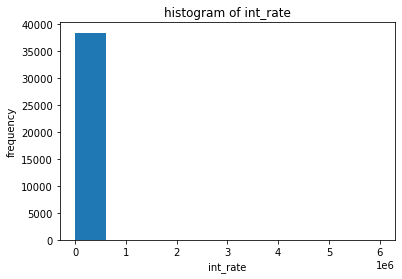

In [19]:
fig,ax = plt.subplots(1,1)
ax.hist(loan_df['annual_inc'])
ax.set_title("histogram of int_rate")
ax.set_xlabel('int_rate')
ax.set_ylabel('frequency')
plt.show()



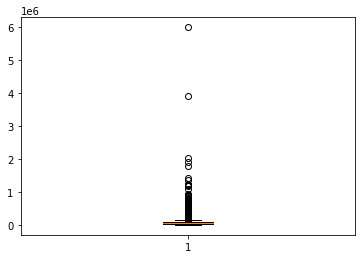

In [20]:
plt.boxplot([loan_df['annual_inc']])
plt.show()

annual income has many outliers because of which bins classification is not appropriate and therefore only one bar is seen in plot, therefore removing the outliers

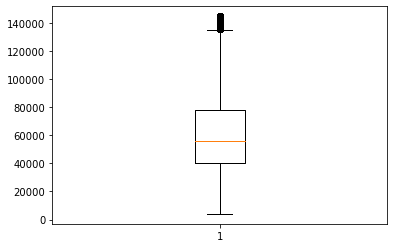

In [21]:
Q1 = loan_df['annual_inc'].quantile(0.25)
Q3 = loan_df['annual_inc'].quantile(0.75)
IQR = Q3 - Q1
loan_df = loan_df[((Q1 - 1.5*IQR) <= loan_df['annual_inc']) &  (loan_df['annual_inc'] <= (Q3 + 1.5*IQR))]

plt.boxplot([loan_df['annual_inc']])
plt.show()

##### Bucketizing some of the Numeric Variables (making it categorical)
1. Loan_amnt
2. annual_income
3. dti - debt to income ratio

Binning annual income

In [22]:
loan_df['annual_inc'].describe()

count     36719.000000
mean      61218.966784
std       28226.033567
min        4000.000000
25%       40000.000000
50%       56000.000000
75%       78000.000000
max      145000.000000
Name: annual_inc, dtype: float64

In [23]:
loan_df['binned_annual_inc'] = pd.cut(loan_df['annual_inc'], bins=[0,30000,60000,90000,120000,150000], labels =['very low','low','medium','high','very high'] )
loan_df['binned_annual_inc'].head(2)

0    very low
1    very low
Name: binned_annual_inc, dtype: category
Categories (5, object): ['very low' < 'low' < 'medium' < 'high' < 'very high']

Binning Loan amount

In [24]:
loan_df['binned_loan_amnt'] = pd.cut(loan_df['loan_amnt'], bins=[0,7000,14000,21000,28000,35000], labels =['very low','low','medium','high','very high'] )
loan_df['binned_loan_amnt'].head(2)

0    very low
1    very low
Name: binned_loan_amnt, dtype: category
Categories (5, object): ['very low' < 'low' < 'medium' < 'high' < 'very high']

In [25]:
loan_df['binned_dti'] = pd.cut(loan_df['dti'], bins=[-1,10,15,20,25,30], labels =['very low','low','medium','high','very high'] )
loan_df['binned_dti'].head(2)

0    very high
1     very low
Name: binned_dti, dtype: category
Categories (5, object): ['very low' < 'low' < 'medium' < 'high' < 'very high']

###### Processing some columns and converting them to numeric

Converting int_rate, term and emp_length to numeric

In [26]:
#slice '%' sign of int_rate and convert in int
def column_slice_conv(col_name,number_of_char):
    print(col_name)
    loan_df[col_name]=loan_df[col_name].apply(lambda x: x[:len(x)-number_of_char])
    loan_df[col_name]=loan_df[col_name].apply(pd.to_numeric)
    
column_slice_conv('int_rate',1)

loan_df.int_rate.head(2)

int_rate


0    10.65
1    15.27
Name: int_rate, dtype: float64

In [27]:
# column_slice_conv('term',6)
loan_df['term']=loan_df['term'].apply(lambda x: x[:-6])
# loan_df['term'].head(2)

In [28]:
#extracting years of employmet length, here 10 implies >10years, and 1 implies less than 1 year
loan_df.emp_length=loan_df.emp_length.str.extract('(\d+)')

In [29]:
loan_df.emp_length.unique()

array(['10', '1', '3', '8', '9', '4', '5', '6', '2', '7', nan],
      dtype=object)

## Imputing Nulls

In [30]:
#checking all columns having
loan_df.isnull().sum()[loan_df.isnull().sum()>0]

emp_title               2212
emp_length              1016
pub_rec_bankruptcies     658
dtype: int64

In [31]:
loan_df['emp_length'].unique()

array(['10', '1', '3', '8', '9', '4', '5', '6', '2', '7', nan],
      dtype=object)

Replacing NA in emp_length with its mode, i.e the most frequent employee length which is coming as 10+


In [32]:
loan_df['emp_length'].fillna(loan_df['emp_length'].mode()[0],inplace = True)

In [33]:
loan_df['emp_length'].unique()

array(['10', '1', '3', '8', '9', '4', '5', '6', '2', '7'], dtype=object)

considering nan in pub_rec_bankruptcies means there were no bankrupcy therefore replacing it with 0

In [34]:
loan_df[loan_df['pub_rec_bankruptcies'].isna()].groupby(['loan_status']).sum()['loan_amnt']
loan_df['pub_rec_bankruptcies'].fillna(0,inplace=True)

In [35]:

def replace_null(column_name, replace_by):
    if (replace_by == 'mode'):
        loan_df[column_name].fillna(loan_df[column_name].mode()[0], inplace = True)
    elif (replace_by == 'median'):
        loan_df[column_name].fillna(loan_df[column_name].median()[0], inplace = True)
    elif (replace_by == 'mean'):
        loan_df[column_name].fillna(loan_df[column_name].mean()[0], inplace = True)
        
replace_null('emp_title', 'mode')

loan_df.isnull().sum()[loan_df.isnull().sum()>0]

Series([], dtype: int64)

## Checking Correlation between Numerical variables and dropping columns accordingly

<AxesSubplot:>

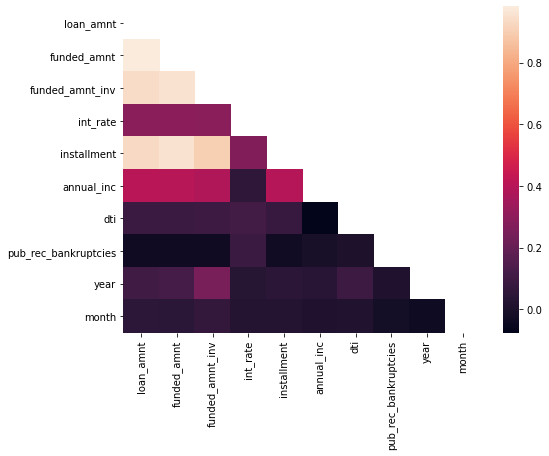

In [36]:
fig, ax = plt.subplots(figsize=(8,6)) 
mask = np.triu(np.ones_like(loan_df.corr()))

sns.heatmap(loan_df.corr(), ax=ax, mask=mask)

Removing Columns based on correlation since it doesn't make sense to keep 2 variables giving same information

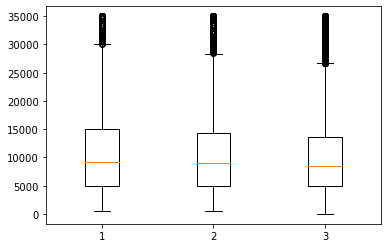

In [37]:
plt.boxplot ([loan_df['loan_amnt'], loan_df['funded_amnt'], loan_df['funded_amnt_inv']])
plt.show()

'loan_amnt', 'funded_amnt', 'funded_amnt_inv'- All these 3 features have very high correlation and also have same variations, therefore removing  'funded_amnt', 'funded_amnt_inv'and keeping 'loan_amnt'

In [38]:
loan_df.drop(columns = ['funded_amnt','funded_amnt_inv'], inplace = True)

We can still see some high correlations, e.g installments and loan amnt, this is because the number of installments tends to increase if the loan amount increases.

<AxesSubplot:>

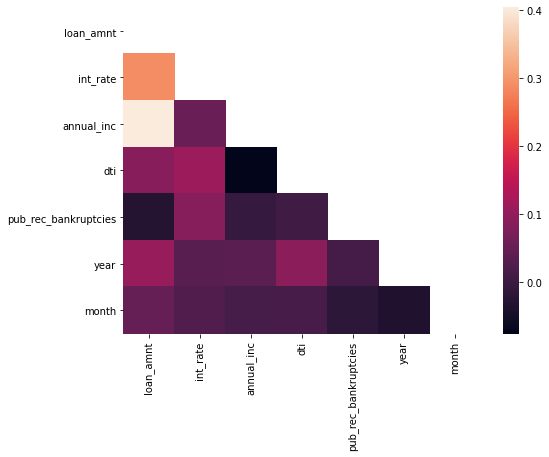

In [39]:
loan_df.drop(columns = ['installment'],inplace = True)


fig, ax = plt.subplots(figsize=(8,6)) 
mask = np.triu(np.ones_like(loan_df.corr()))

sns.heatmap(loan_df.corr(), ax=ax, mask=mask)

## Numeric Univariate analysis and bucketized variable analysis

Univariate analysis of loan_amnt, int_rate gives us an understanding about their distribution across the range.

Plotting the loan amount and the binned loan amount, to analyse the distribution

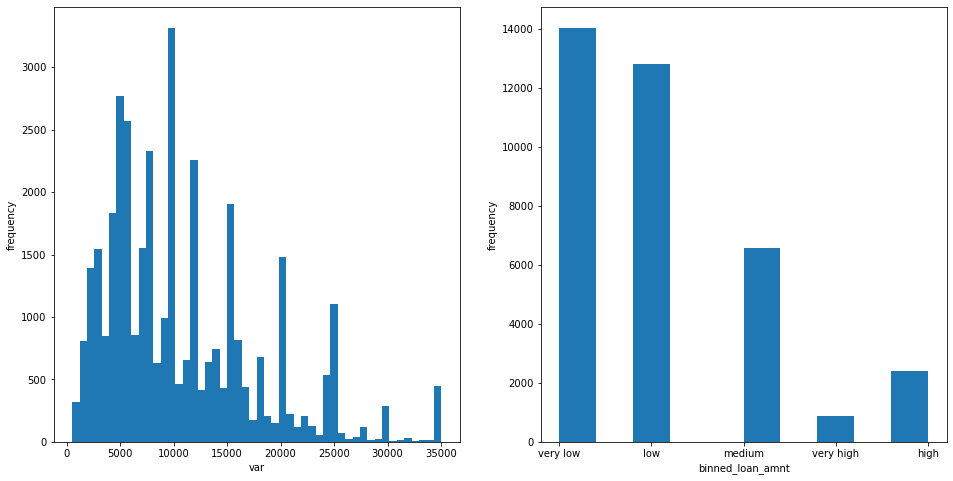

In [40]:
# this function will plot binned and unbinned distribution for the variable passed
def df_sum_count_plot(var, bin_var):
    plt.figure(figsize=(16, 8)) 
    plt.subplot(1,2,1)
    #This will create a loan amount distribution graph
    
    gdp =plt.hist(loan_df[var], bins=50)
    plt.xlabel('var')
    plt.ylabel('frequency')
#     plt.xticks([],[])
    plt.subplot(1,2,2)
#    
    #This will create the loan amount distribution graph for binned loan values
    pop = plt.hist(loan_df[bin_var])
    plt.ylabel('frequency')
    plt.xlabel(bin_var)
#     
#     plt.xticks(df_s["main_sector_"], rotation='vertical')
    plt.show()
    
df_sum_count_plot('loan_amnt', 'binned_loan_amnt')

We can observe that as loan amount increases, number of people taking loan decreases. The amount of 10000 is taken most frequently.
We can also observe that most of the loan amount is taken at multiple of 2500, therefre there are unusually high spikes there.

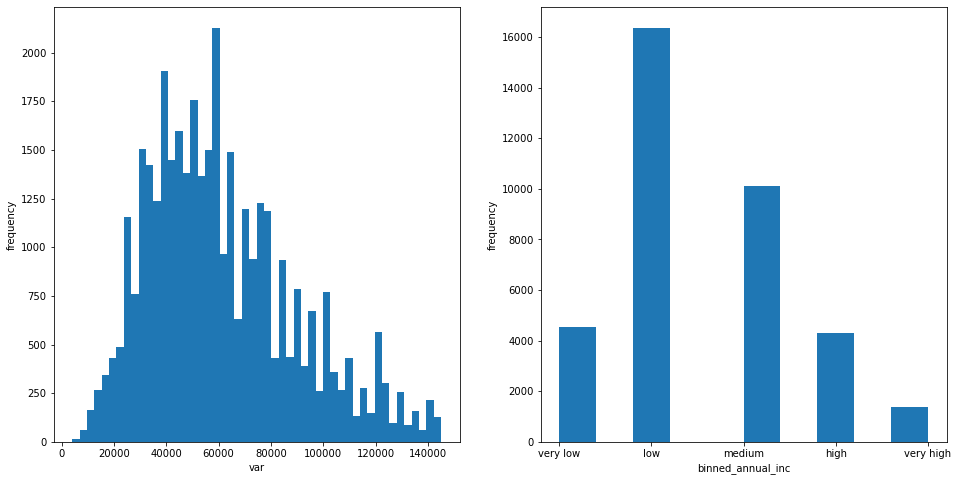

In [41]:
#plotting the univariate for Annual Income

df_sum_count_plot('annual_inc', 'binned_annual_inc')

As expected, annual income is a right skewed plot, because very less people have very high salaries.

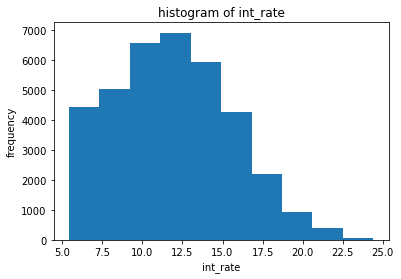

In [42]:
#Analysing interest rates

fig,ax = plt.subplots(1,1)
ax.hist(loan_df['int_rate'])
ax.set_title("histogram of int_rate")
ax.set_xlabel('int_rate')
ax.set_ylabel('frequency')
plt.show()



Most of the int rates lie between 10-12.5%

In [43]:
# loan_df.plot.bar(x="grade", y="int_rate")
# plt.show()

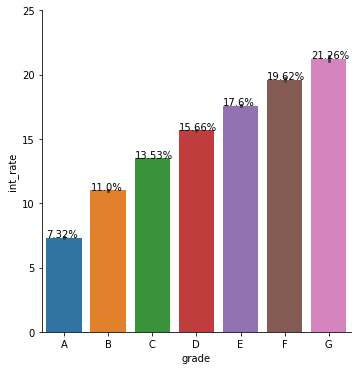

In [44]:
loan_df = loan_df.sort_values(by=['grade'], ascending = True) # sorting dataframe on basis of grades
g = sns.catplot(x='grade',y='int_rate',kind='bar',data=loan_df ) # catplot used  to establish relation between interest rate and grade
g.ax.set_ylim(0,25)
# sns.set(rc={'figure.figsize':(13,8.27)})
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    
#plt.xticks(rotation=90)
plt.show()

Grades are basically the binned version of interest rates. Interest rate increase from grade A to G

In [45]:
loan_df['dti'].describe()

count    36719.000000
mean        13.442623
std          6.661551
min          0.000000
25%          8.340000
50%         13.570000
75%         18.700000
max         29.990000
Name: dti, dtype: float64

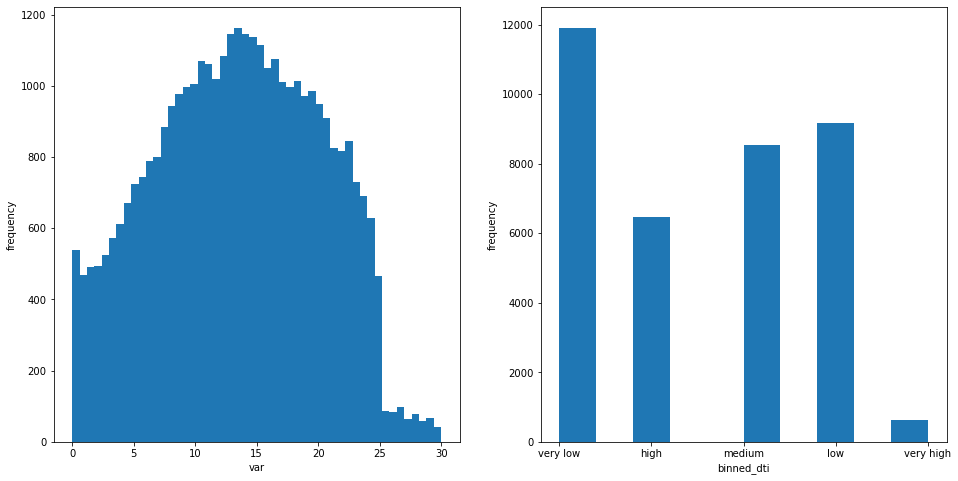

In [46]:
df_sum_count_plot('dti', 'binned_dti')

Dti is debt by income ratio, therefore we will prefer a low dti ratio for giving a loan. 
By the plot above, we can see that there is sudden drop in number of loans being sanctioned for people having dti above 25. We can conclude that the bank has preferred approving loan for people majorly havingdti less than 25

In [47]:
loan_df.groupby('term')['loan_amnt'].median()
# people who take loan for 36 months take around 8k of loan, while people with 60 mnths take around 15k of loan

term
 36      8000
 60     14075
Name: loan_amnt, dtype: int64

People usually take high amount of loan for longer term. We can see that the representative value for 36 months is almost half that of 60 months

### Univariate Categorical Analysis


Text(0.5, 1.0, 'Grade Distribution')

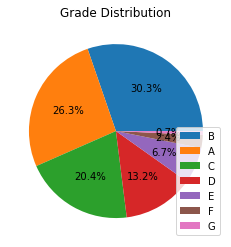

In [48]:
plt.pie(loan_df["grade"].value_counts(1)*100, autopct='%1.1f%%')
plt.legend(loan_df["grade"].value_counts().index,loc='lower right')
plt.title("Grade Distribution")

Text(0.5, 1.0, 'term Distribution')

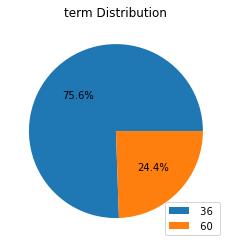

In [49]:
plt.pie(loan_df["term"].value_counts(1)*100, autopct='%1.1f%%')
plt.legend(loan_df["term"].value_counts().index,loc='lower right')
plt.title("term Distribution")

Text(0.5, 1.0, 'home_ownership category Distribution')

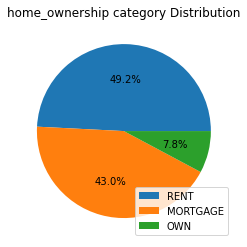

In [50]:
plt.pie(loan_df["home_ownership"].value_counts(1)*100, autopct='%1.1f%%')
plt.legend(loan_df["home_ownership"].value_counts().index,loc='lower right')
plt.title("home_ownership category Distribution")

Text(0.5, 1.0, 'emp_length distribution')

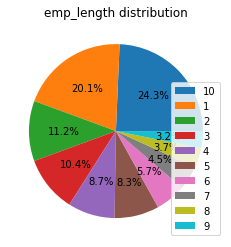

In [51]:
plt.pie(loan_df["emp_length"].value_counts(1)*100, autopct='%1.1f%%')
plt.legend(loan_df["emp_length"].value_counts().index,loc='lower right')
plt.title("emp_length distribution")

## Categorical Analysis

In this section we will analyse frequency of different loan status for each category of a variable. Also to get an idea of what % of loans are resulting in charged off out of total loans sanctioned for each respective category, we will plot the line graph indicating percentage charged off for each category of a variable

We will analyse the total count of loans for different variables for each loan status

Also, We will analyse the crosstab of loan_status with the different variables. for example, if we want to analyse that out of all the people who took loan for 60 moths, what percentage of people are not able to pay the loan. We will compare this percentage with let's say people who took loan for 36 months and are charged off.
Percent_chargedoff for 36 months = number of people who took loan for 36 months and were charged off/total number of people who took loan for 36 months
Percent_chargedoff for 60 months = number of people who took loan for 60 months and were charged off/total number of people who took loan for 60 months

Comparing these 2 charged off percentage, we will be able to know that for which category (36 or 60 months), there is high probability of a loan being charged off

In [52]:
loan_df.columns 

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'addr_state', 'dti',
       'pub_rec_bankruptcies', 'year', 'month', 'binned_annual_inc',
       'binned_loan_amnt', 'binned_dti'],
      dtype='object')

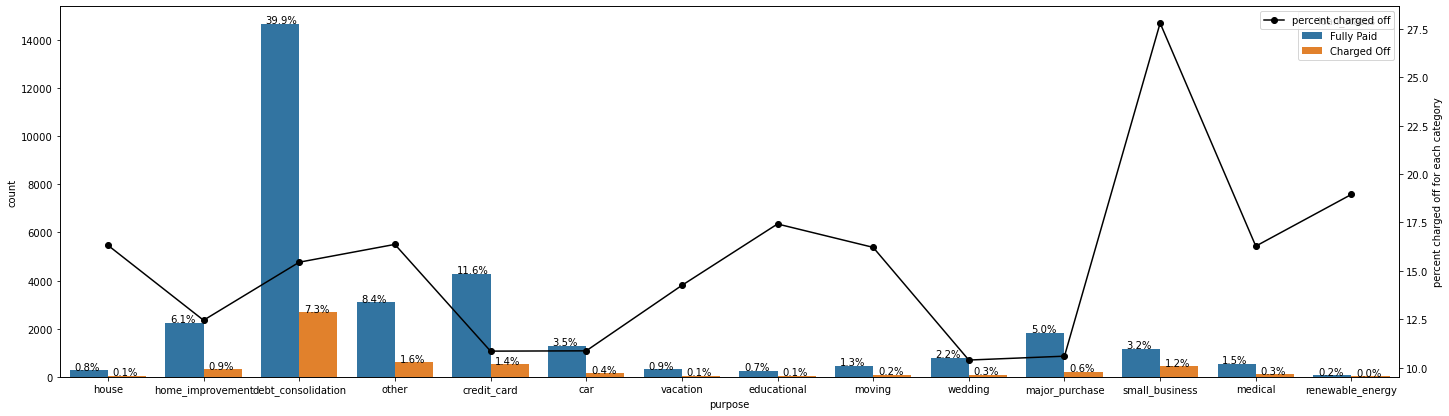

In [53]:
def cat_analysis(x_var, hue_var, df_cat = loan_df):
    df1 = df_cat.groupby(x_var)[hue_var].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent charged off').reset_index()
    temp = pd.Series(data = hue_var)
    fig, ax = plt.subplots()
    width = len(df_cat[x_var].unique()) + 6 + 4*len(temp.unique())
    fig.set_size_inches(width , 15)

    plt.subplot(2,1,1)
    ax = sns.countplot(x=x_var,hue=hue_var,data=df_cat)
    ax2=ax.twinx()
    for p in ax.patches:
        
        ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(df_cat))), (p.get_x()+0.05, p.get_height()+20))

    df1 = df1[df1[str(df1.columns[1])] == 'Charged Off']
    
    l1=list(df_cat[x_var].unique())
    temp_df=pd.DataFrame({x_var:l1})
    df1=temp_df.merge(df1, on = x_var, how='left')
    
#     print(df1)
    df1.plot(x=x_var,y='percent charged off',ax=ax2, marker='o', color = 'black')
    plt.legend(loc="upper right")
    plt.xlim((-0.5, len(df1)-0.5))
    ax2.set_ylabel('percent charged off for each category')
    
#     for q in ax2.patches:
#         print(q,q.get_x())
#         ax2.annotate('{:1.1f}%'.format((q.get_height())/float(len(df1))), (q.get_x(), q.get_height()))
#     for k, v in df1.iterrows():
#         ax2.annotate(k, v)
#         print(v[2])
#     print(df1)
    
cat_analysis("purpose","loan_status")

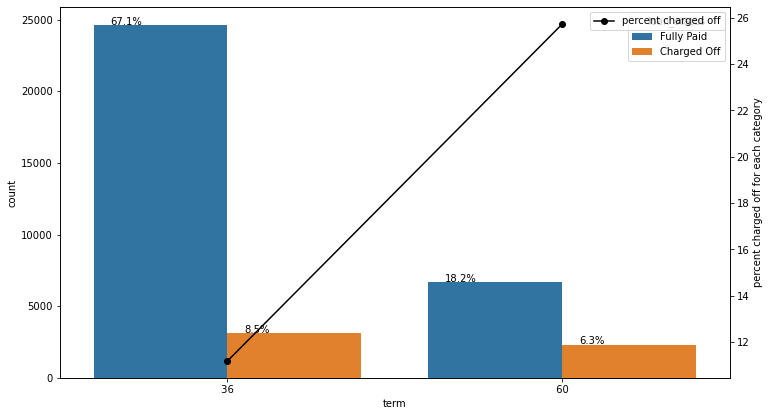

In [54]:
cat_analysis("term","loan_status")

In [55]:
# df1 = loan_df.groupby('purpose')['loan_status'].value_counts(normalize=True)
# df1 = df1.mul(100)
# df1 = df1.rename('percent charged off').reset_index()
# df1 = df1[df1[str(df1.columns[1])] == 'Charged Off']
# plt.figure(figsize=(16, 8))
# fig.set_size_inches(20 , 15)
# df1.plot(x='purpose',y='percent charged off', marker='o', color = 'black',figsize = (20,15))
# plt.xlim((-0.5, len(df1)-0.5))

In [56]:
# sns.barplot(x=loan_df['purpose'], y=loan_df['loan_amnt'], hue = loan_df['loan_status'])

We can see from above analysis, that out of all the loans sanctioned for 60 months term, 25.7% of the loans resulted in charged off, while it is only 11% for 36 months term, therefore there are more chances for loan to be charged off for 60 months as compared to 36 months.

Here the line plot shows that out of all the people who took loan for 60 months, the % of charged off loans is higher as compared to the charged off loans sanctioned for 36 months
The charged off percentage is highest for 60 months term as compared to that sanctioned for 36 months. 


Now if we analyse the clustetred bar graph, we will get to know that people taking loan for 36 month duration are much more in number than people taking loan for 60 months. Large amount of loans have usually longer term, and that's why the frequency of taking larger loans is less than taking smaller loans, but the chances of repayment is smaller for larger term (as can be seen by line graph)

Only 11% of the loans taken for 36 months were charged off, while it was 22.6% for 60 months term

In [57]:
# # loan_df['binned_dti']=loan_df['binned_dti'].astype(object)
# loan_df.info()

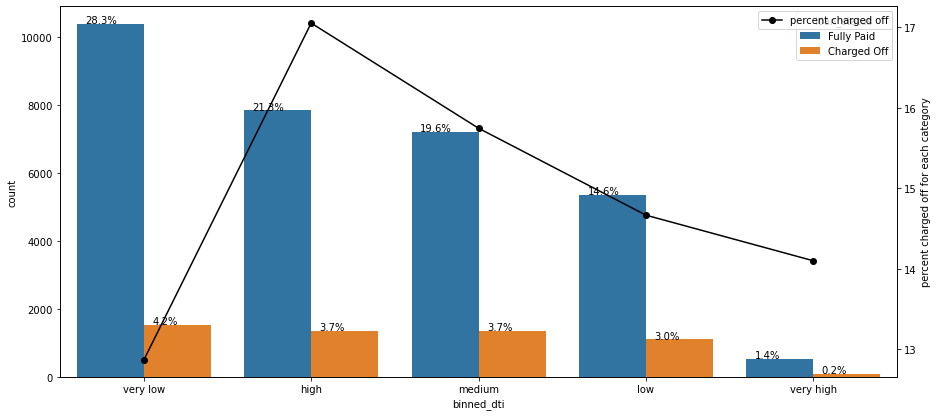

In [58]:
cat_analysis("binned_dti","loan_status")


We can see that the chances of charged off is higher for people having dti around 20-25. The banks are giving less number of loans to people having dti of 30 after careful considerations, but they should do some extra checks for dti in range 20-25 also, hence reducing the chances of charged off

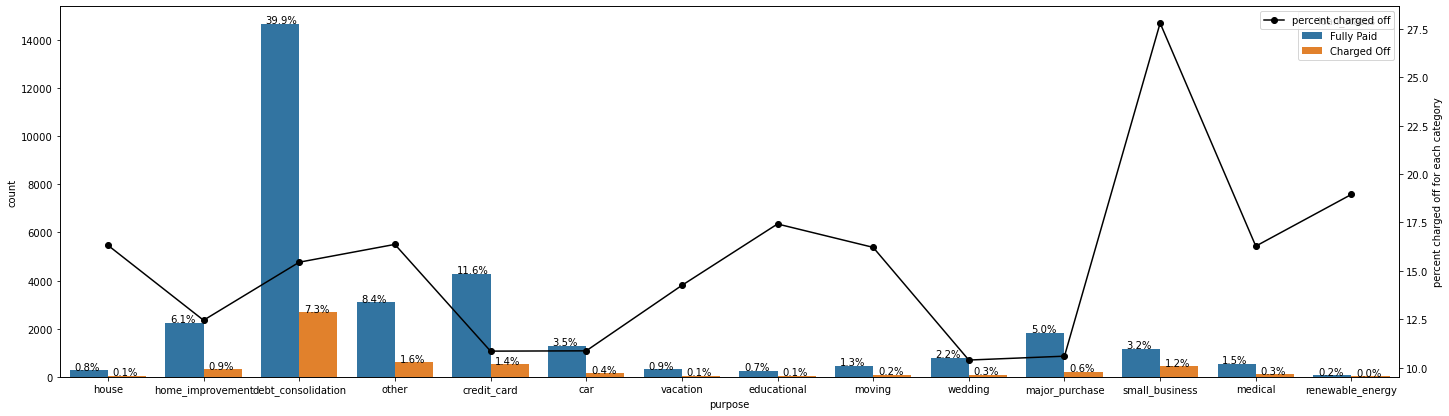

In [59]:
cat_analysis("purpose","loan_status")

We can see that the chances of charged off is higher for people taking loan for small businesses. Though the highest number of loans are taken for debt_consolidation, but the chances of charged off are quite low there.

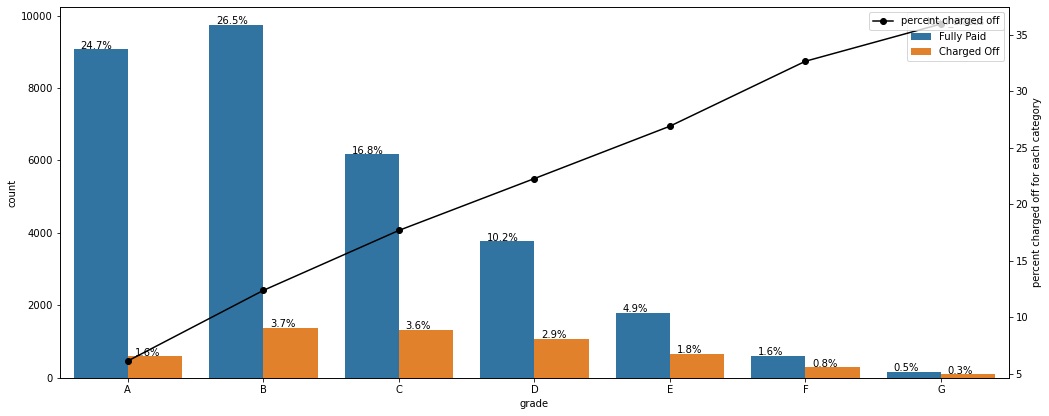

In [60]:
cat_analysis("grade","loan_status")

As we saw before that interest rates were least for A grade and highest for G, therefore the chances of charged off are highest for G grade loans( can be seen in line graph). Although the highest number of loans are taken for grade A, due to obvious low interest rates, therefore the chances of charged off being least there.

From the above analysis, we can see that maximum percentage of defaulters are from grade G. We know that grade G have high interest rates, which might be the reason for large number of defaulters.

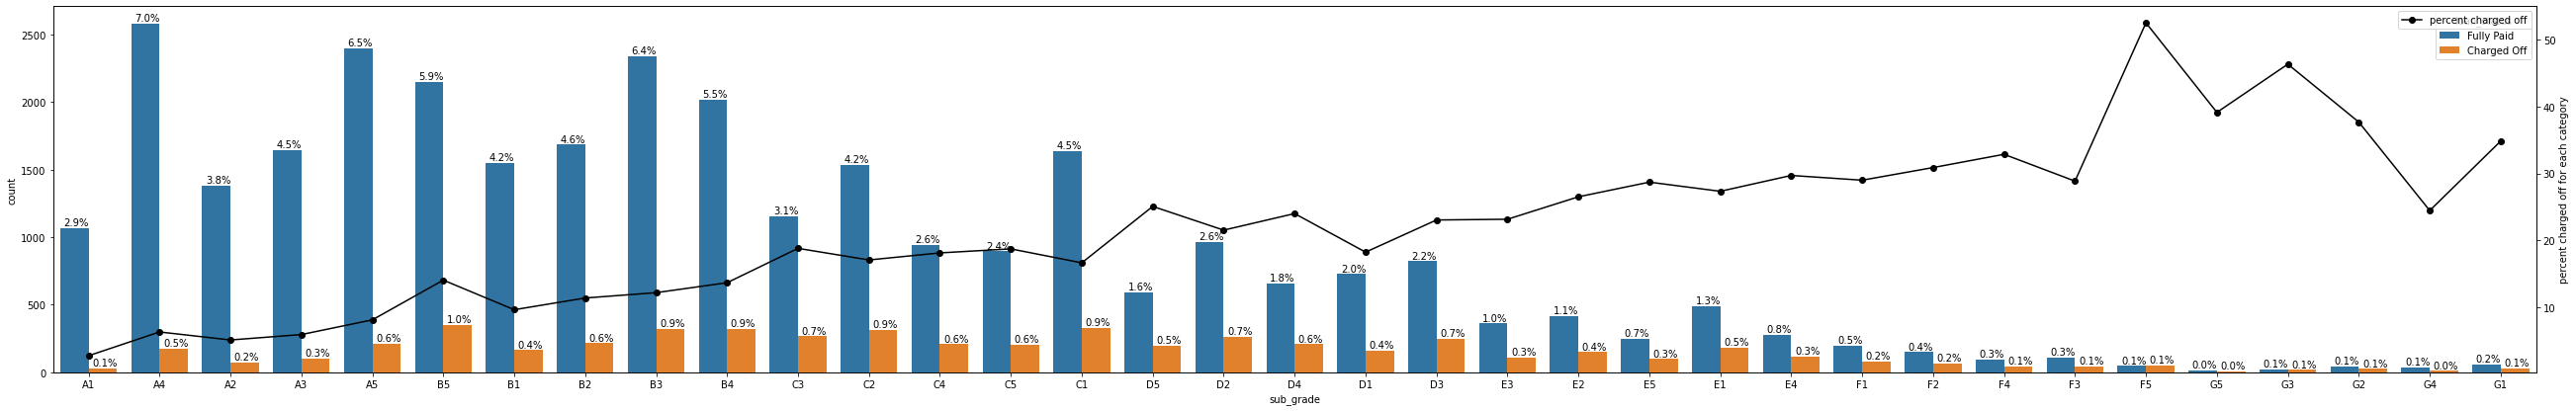

In [61]:
cat_analysis("sub_grade","loan_status")

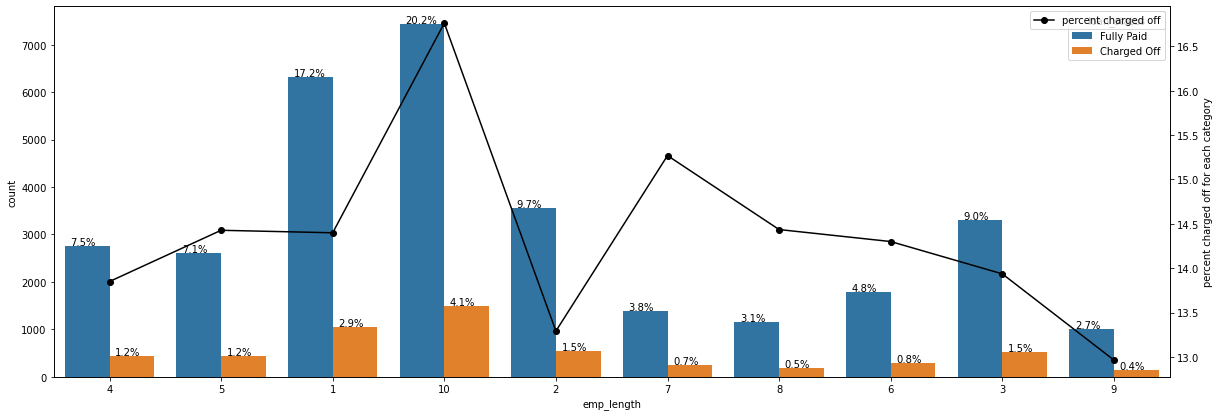

In [62]:
cat_analysis("emp_length","loan_status")

People having less than 1 year of experience, and more than 10 years of experience have highest number of loans sanctioned for. But the percent of charged off loans are highest for 10+ years

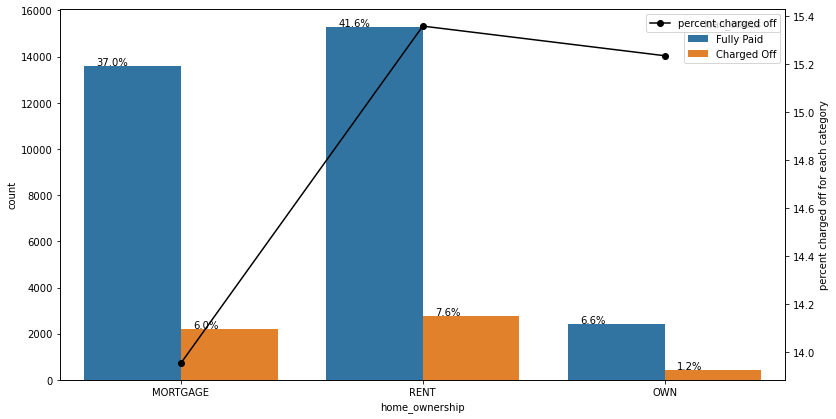

In [63]:
cat_analysis("home_ownership","loan_status")

Rent, followed by 'own' has the highest chances of charged off loans out of total loans sanctioned for respective category

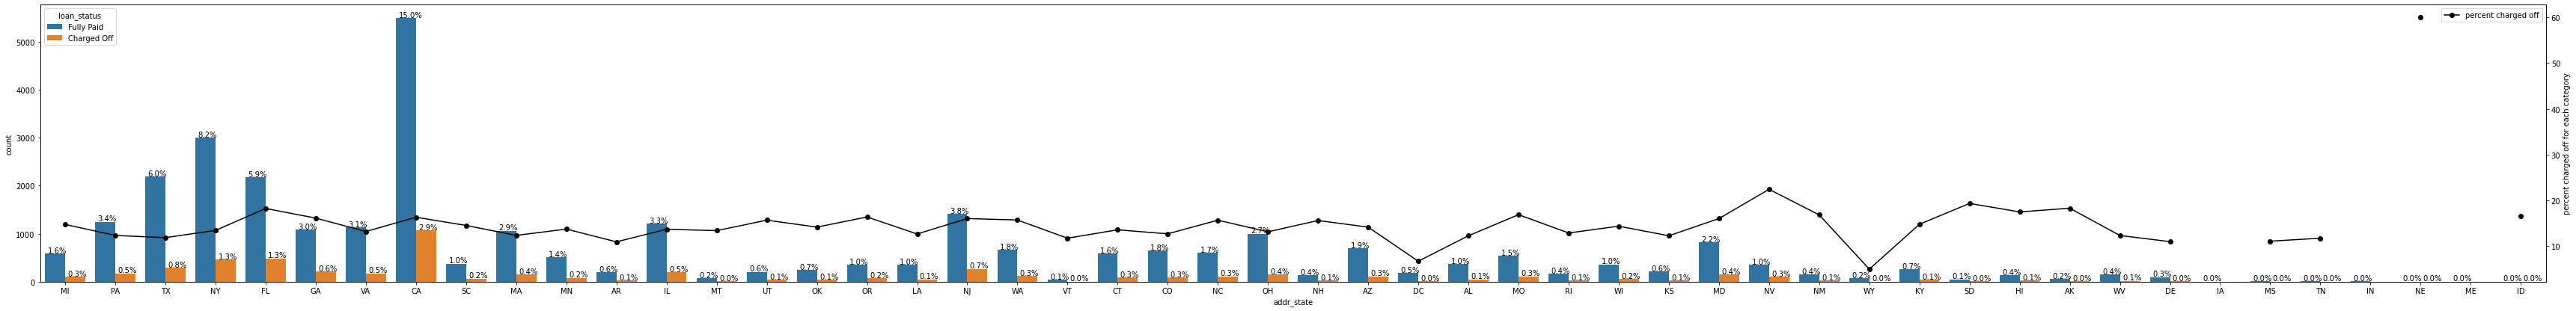

In [64]:
cat_analysis("addr_state","loan_status")

DC has highest number of charged off loan sanctioned, while NE has highest percentage of charged off loans out of total loans sanctioned for NE

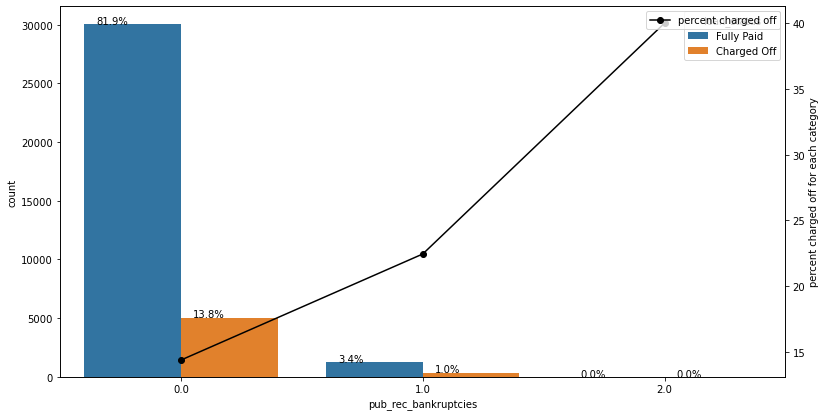

In [65]:
cat_analysis("pub_rec_bankruptcies","loan_status")
# loan_df.columns

The chances of charged off are highest where the public recorded bankrupcies are 2

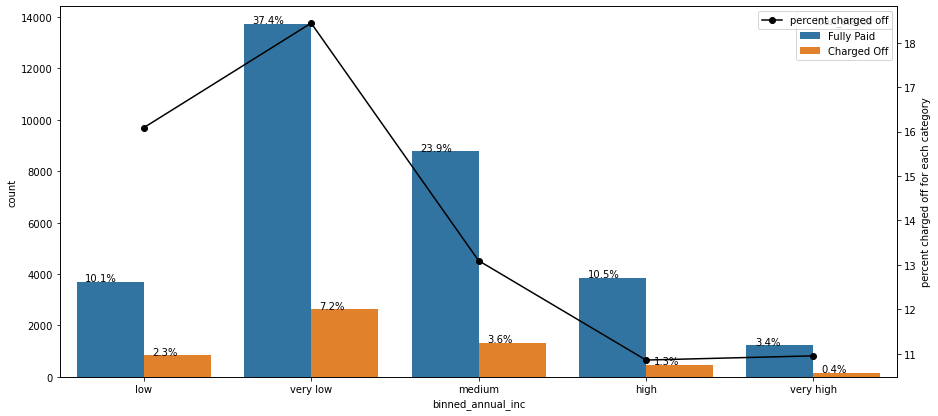

In [66]:
cat_analysis("binned_annual_inc","loan_status")
# loan_df.columns

People having low income have high chances of beong charged off

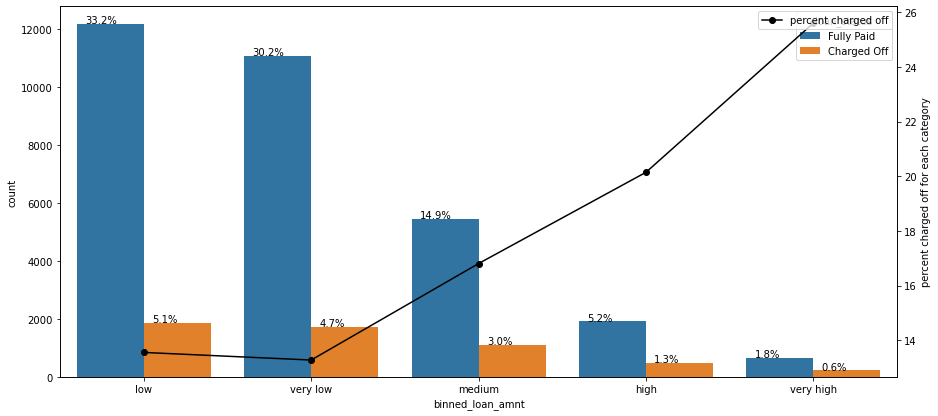

In [67]:
cat_analysis("binned_loan_amnt","loan_status")
# loan_df.columns

People taking high loan amount have high chances of being in charged off state.

<AxesSubplot:xlabel='year', ylabel='count'>

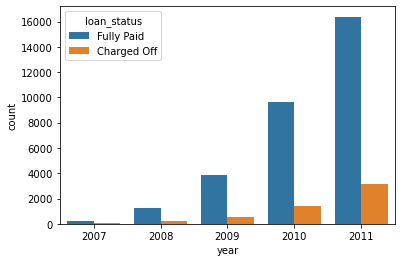

In [68]:

sns.countplot(x = loan_df['year'], hue = loan_df['loan_status'])
#number of loans taken are increasing year by year

In [69]:
loan_df['loan_amnt'].sum()

393184375

## MULTIVARIATE ANALYSIS

<AxesSubplot:xlabel='purpose', ylabel='loan_amnt'>

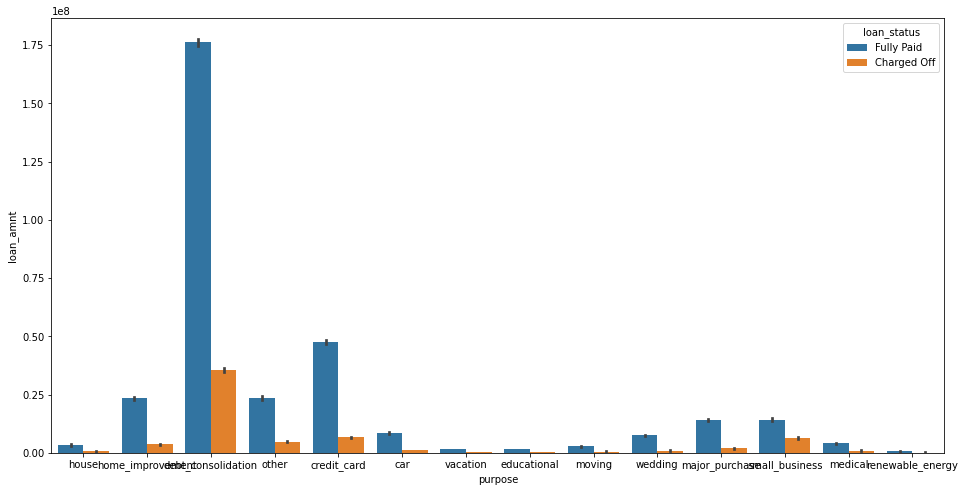

In [70]:
# tdf=loan_df.groupby(['purpose','loan_status'])['loan_amnt'].sum().reset_index()
# sns.barplot(x=tdf['purpose'], y=tdf['loan_amnt'], hue = tdf['loan_status'])
plt.figure(figsize=(16, 8)) 
sns.barplot(x=loan_df['purpose'], y=loan_df['loan_amnt'], hue = loan_df['loan_status'],estimator = sum)
#     ax2=ax.twinx()

<ipython-input-71-6c64ae3900cd>:16: RuntimeWarning: overflow encountered in long_scalars
  ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float((df_cat['loan_amnt'].sum()))), (p.get_x()+0.05, p.get_height()+20))


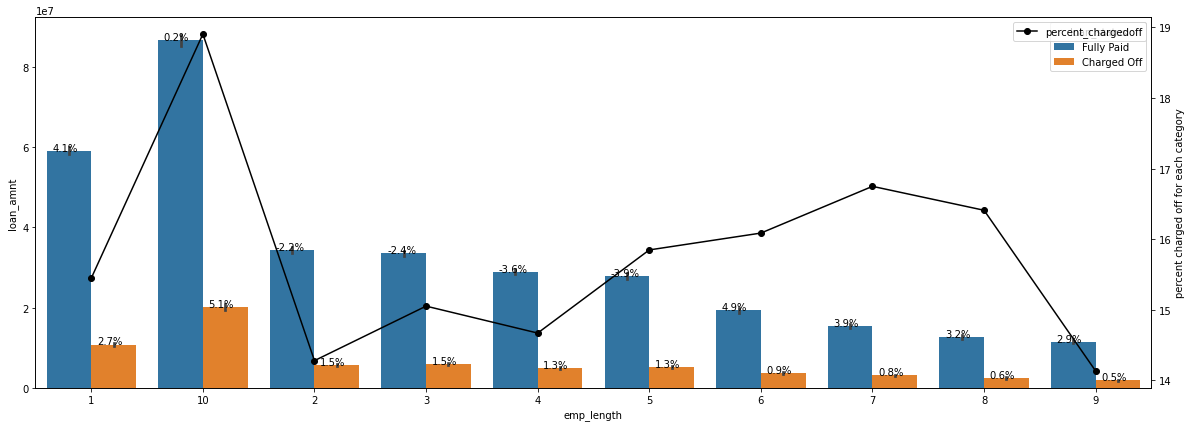

In [71]:

def cat_bivariate(x_var, y_var,hue_var, df_cat = loan_df):
    df_cat=df_cat.sort_values(by = x_var)
#     df1 = df_cat.groupby(x_var)[hue_var].value_counts(normalize=True)
#     df1 = df1.mul(100)
#     df1 = df1.rename('percent charged off').reset_index()
    temp = pd.Series(data = hue_var)
    fig, ax = plt.subplots()
    width = len(df_cat[x_var].unique()) + 6 + 4*len(temp.unique())
    fig.set_size_inches(width , 15)

    plt.subplot(2,1,1)
    ax = sns.barplot(x=df_cat[x_var], y=df_cat[y_var], hue = df_cat[hue_var],estimator = sum)
    ax2=ax.twinx()
    for p in ax.patches:
        
        ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float((df_cat['loan_amnt'].sum()))), (p.get_x()+0.05, p.get_height()+20))

#     df1 = df1[df1[str(df1.columns[1])] == 'Charged Off']
    
    df=pd.pivot_table(df_cat, values='loan_amnt', index=[x_var],
                    columns=['loan_status'], aggfunc=np.sum).reset_index()
    df['total']=df['Charged Off']+df['Fully Paid']
    df['percent_chargedoff']=df['Charged Off']*100/df['total']
#     plt.subplot(2,1,2)
    df.plot(x=x_var,y='percent_chargedoff', ax=ax2,marker='o', color = 'black')
#     sns.lineplot(data=df, x=x_var, y="percent_chargedoff")
    
    
    
    plt.legend(loc="upper right")
    plt.xlim((-0.5, len(df)-0.5))
    ax2.set_ylabel('percent charged off for each category')
    
cat_bivariate("emp_length","loan_amnt", "loan_status")

In [72]:
# df=pd.pivot_table(loan_df.sort_values(by = 'purpose'), values='loan_amnt', index=['purpose'],
#                     columns=['loan_status'], aggfunc=np.sum).reset_index()
# df['total']=df['Charged Off']+df['Fully Paid']
# df['percent_chargedoff']=df['Charged Off']*100/df['total']
# # plt.subplot(2,1,2)
# # df.plot(x=x_var,y='percent_chargedoff', marker='o', color = 'black')
# df

In [73]:
loan_df.sort_values(by = 'purpose')['purpose'].unique()

array(['car', 'credit_card', 'debt_consolidation', 'educational',
       'home_improvement', 'house', 'major_purchase', 'medical', 'moving',
       'other', 'renewable_energy', 'small_business', 'vacation',
       'wedding'], dtype=object)

The chances of being charged off is high for people having 10+ years of emp lengtht and also have highest loan amount under charged off status

<ipython-input-71-6c64ae3900cd>:16: RuntimeWarning: overflow encountered in long_scalars
  ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float((df_cat['loan_amnt'].sum()))), (p.get_x()+0.05, p.get_height()+20))


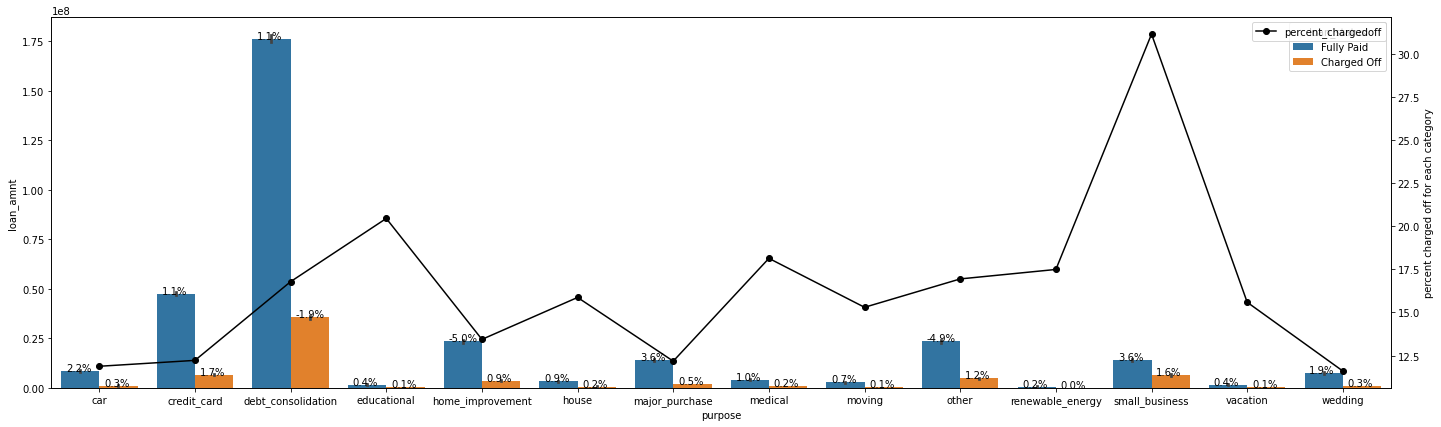

In [74]:
cat_bivariate("purpose","loan_amnt", "loan_status",loan_df)

<ipython-input-71-6c64ae3900cd>:16: RuntimeWarning: overflow encountered in long_scalars
  ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float((df_cat['loan_amnt'].sum()))), (p.get_x()+0.05, p.get_height()+20))


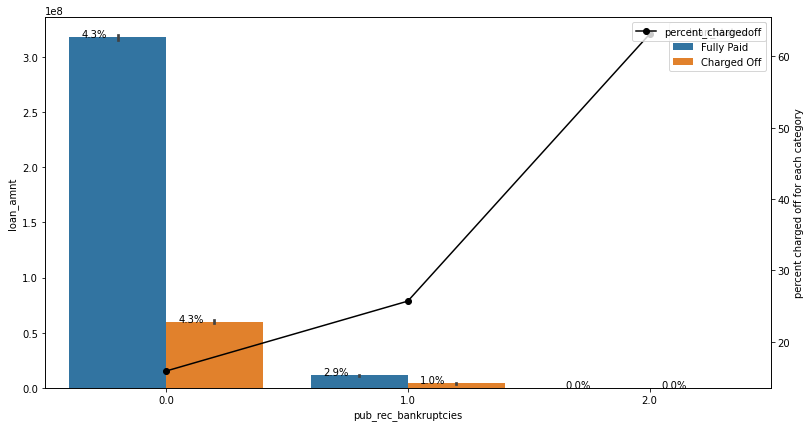

In [75]:
cat_bivariate("pub_rec_bankruptcies","loan_amnt", "loan_status")

There is almost same amount of loan being sanctioned for people having public recorded bankrupcy of 2, although the chances of it being charged off is way too high than others.

<ipython-input-71-6c64ae3900cd>:16: RuntimeWarning: overflow encountered in long_scalars
  ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float((df_cat['loan_amnt'].sum()))), (p.get_x()+0.05, p.get_height()+20))


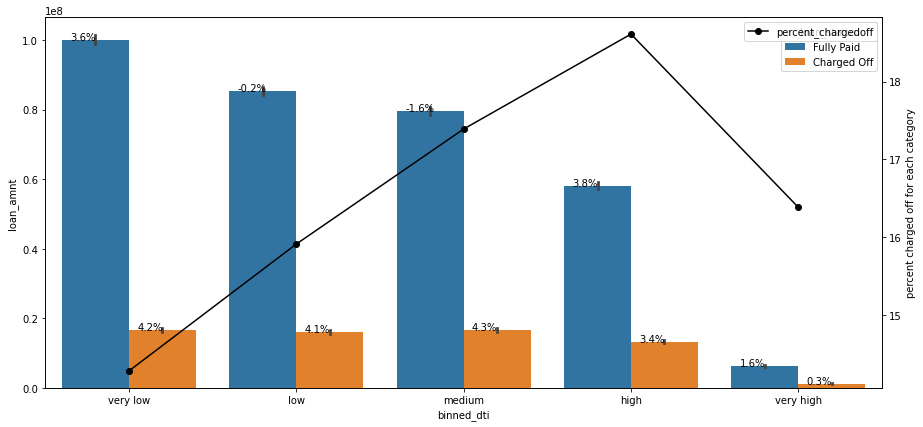

In [76]:
cat_bivariate("binned_dti","loan_amnt", "loan_status")

<ipython-input-71-6c64ae3900cd>:16: RuntimeWarning: overflow encountered in long_scalars
  ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float((df_cat['loan_amnt'].sum()))), (p.get_x()+0.05, p.get_height()+20))


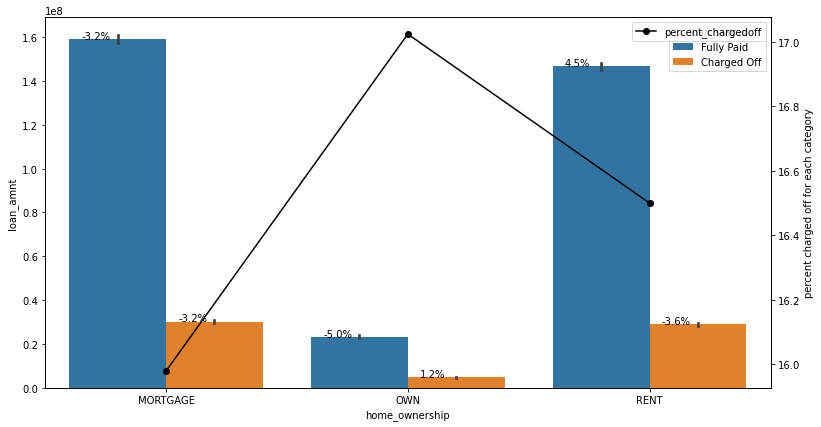

In [77]:
cat_bivariate("home_ownership","loan_amnt", "loan_status")

interestingly, people who own the house have high charged off loan amount

<ipython-input-71-6c64ae3900cd>:16: RuntimeWarning: overflow encountered in long_scalars
  ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float((df_cat['loan_amnt'].sum()))), (p.get_x()+0.05, p.get_height()+20))


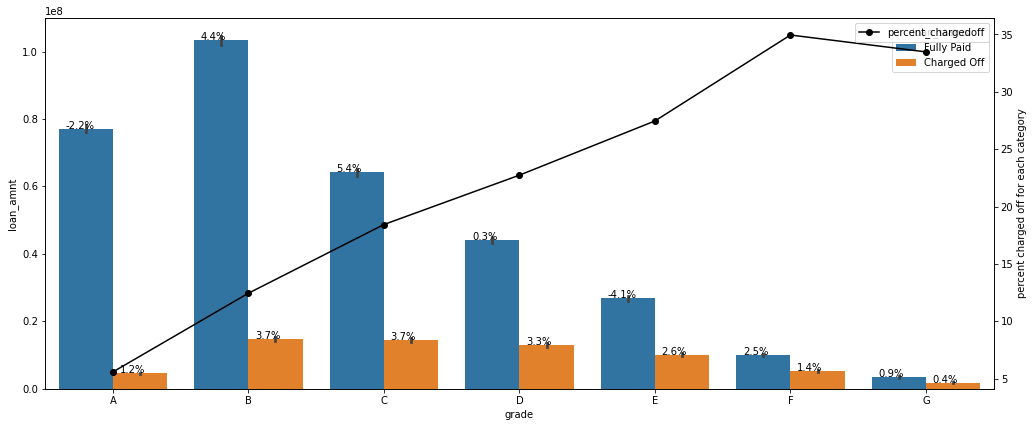

In [78]:
cat_bivariate("grade","loan_amnt", "loan_status")

<ipython-input-71-6c64ae3900cd>:16: RuntimeWarning: overflow encountered in long_scalars
  ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float((df_cat['loan_amnt'].sum()))), (p.get_x()+0.05, p.get_height()+20))


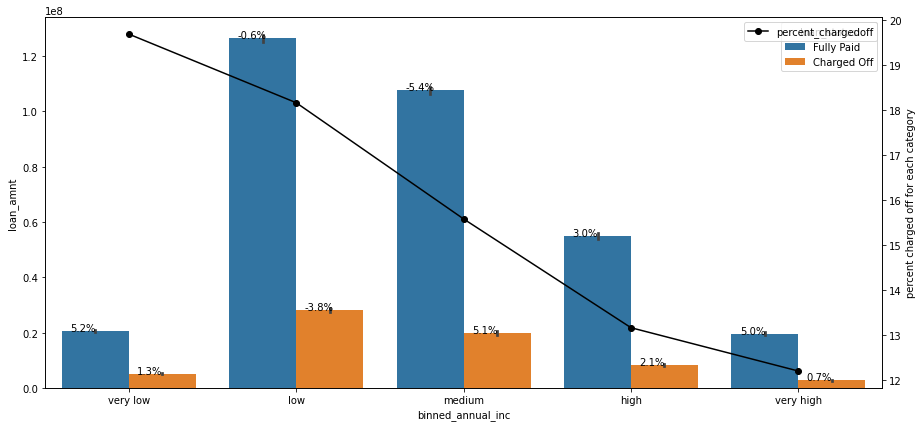

In [79]:
cat_bivariate("binned_annual_inc","loan_amnt", "loan_status")

<ipython-input-71-6c64ae3900cd>:16: RuntimeWarning: overflow encountered in long_scalars
  ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float((df_cat['loan_amnt'].sum()))), (p.get_x()+0.05, p.get_height()+20))


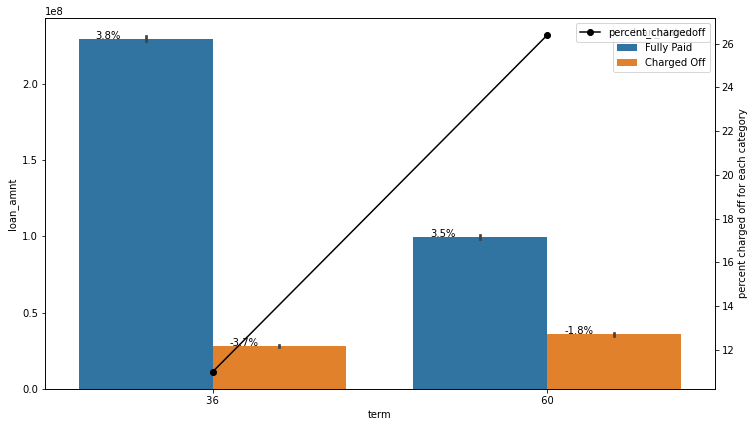

In [80]:
cat_bivariate("term","loan_amnt", "loan_status")

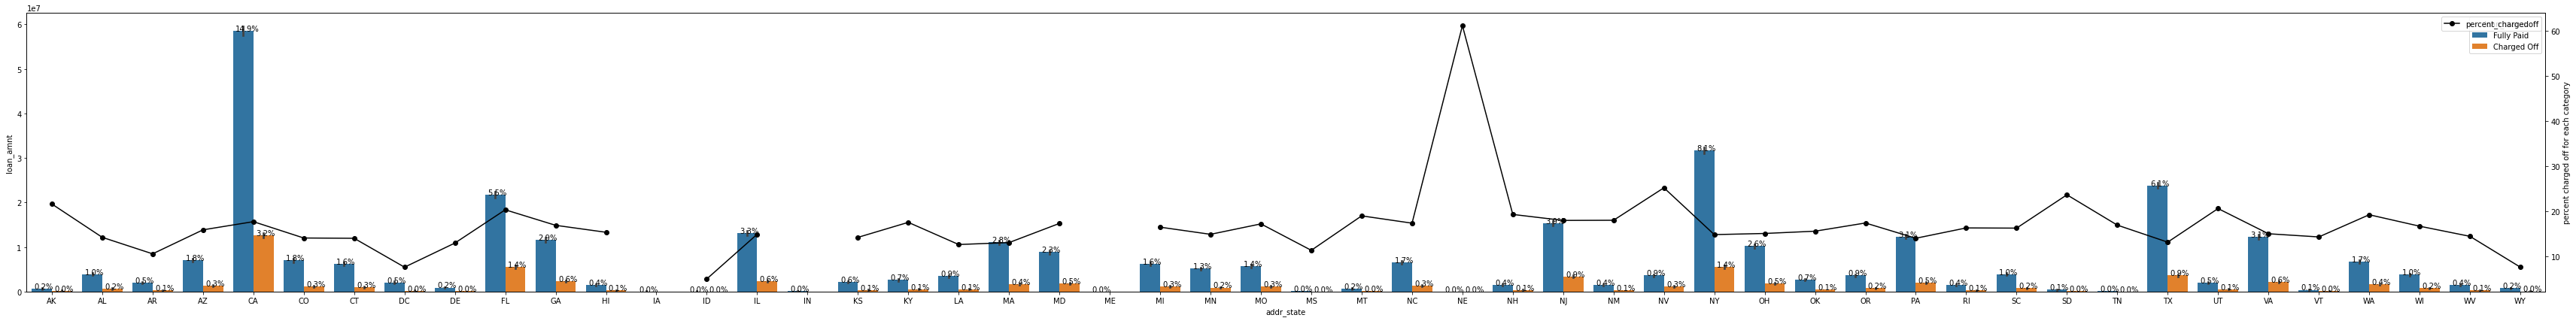

In [81]:
cat_bivariate("addr_state","loan_amnt", "loan_status")

#### PARETO ANALYSIS / ABC analysis

This divides our column into 3 categories, A, B and C. A will have the loans which are making upto approx 60-80 % of the total loan amount. Using this we will be able to easily analyse the chunk which is majorly contributing to loan amount.

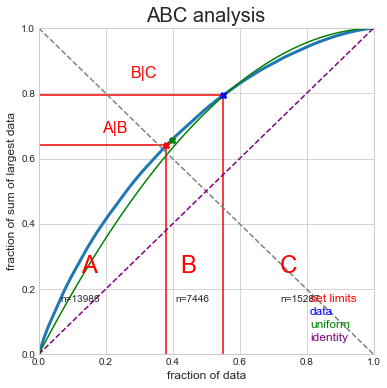

In [82]:
abc = abc_analysis(loan_df['loan_amnt'], True)

In [83]:
abc

{'ABLimit': 11300,
 'BCLimit': 8000,
 'ABexchanged': False,
 'Aind': [0,
  11,
  21,
  34,
  36,
  39,
  55,
  62,
  72,
  83,
  92,
  93,
  98,
  116,
  131,
  137,
  139,
  163,
  164,
  170,
  187,
  188,
  191,
  198,
  199,
  209,
  215,
  217,
  219,
  222,
  227,
  236,
  255,
  256,
  259,
  270,
  272,
  273,
  277,
  284,
  290,
  300,
  308,
  311,
  331,
  334,
  336,
  343,
  351,
  352,
  359,
  361,
  367,
  372,
  373,
  375,
  377,
  389,
  393,
  395,
  396,
  398,
  400,
  401,
  408,
  409,
  422,
  423,
  427,
  435,
  439,
  446,
  450,
  451,
  458,
  461,
  469,
  470,
  477,
  480,
  491,
  498,
  501,
  503,
  515,
  519,
  520,
  525,
  526,
  532,
  536,
  537,
  547,
  550,
  552,
  558,
  560,
  561,
  566,
  569,
  571,
  573,
  587,
  594,
  595,
  602,
  605,
  611,
  628,
  636,
  642,
  647,
  661,
  668,
  669,
  687,
  690,
  697,
  706,
  710,
  711,
  715,
  719,
  720,
  724,
  728,
  739,
  754,
  771,
  777,
  782,
  790,
  792,
  798,
  801,
 

We can see that 38% of the loan records are contributing approx 64% of the loan amount and 55% of toal loans are contributing to 80% of loan amount. Therefore lets analyse these ccategories

In [84]:
a_index = abc['Aind']
b_index =  abc['Bind']
c_index =  abc['Cind']
cond_list = [loan_df.index.isin(a_index),loan_df.index.isin(b_index),loan_df.index.isin(c_index)]
choice_list = ['A','B', 'C']
loan_df['abc']=np.select(cond_list,choice_list)
loan_df.sort_values(by = ['loan_amnt'], ascending = False)
loan_df

,loan_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,purpose,addr_state,dti,pub_rec_bankruptcies,year,month,binned_annual_inc,binned_loan_amnt,binned_dti,abc
13609,12000,36,5.42,A,A1,Better Construction,4,MORTGAGE,31000.0,Not Verified,...,house,MI,5.81,0.0,2011,6,low,low,very low,A
14155,1550,36,7.49,A,A4,leeds world,5,MORTGAGE,22000.0,Not Verified,...,home_improvement,PA,24.87,0.0,2011,6,very low,very low,high,B
14157,9225,36,5.99,A,A2,Applied Materials,5,RENT,63000.0,Not Verified,...,debt_consolidation,TX,15.66,0.0,2011,6,medium,low,medium,A
14161,7525,36,5.99,A,A2,Cantor Fitzgerald &Co,1,RENT,85000.0,Not Verified,...,debt_consolidation,NY,5.29,0.0,2011,6,medium,low,very low,C
33103,6000,36,7.40,A,A2,Greece Central School District,5,MORTGAGE,80000.0,Not Verified,...,other,NY,13.66,0.0,2010,1,medium,very low,low,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2603,35000,60,23.91,G,G4,Military,10,RENT,81500.0,Verified,...,debt_consolidation,MD,21.92,0.0,2011,12,medium,very high,high,A
19430,35000,60,21.22,G,G4,Columbia University,7,MORTGAGE,58000.0,Verified,...,debt_consolidation,NY,16.14,0.0,2011,2,low,very high,medium,C
13687,12000,60,22.11,G,G1,Car-tel Communications,3,RENT,47000.0,Verified,...,small_business,NJ,11.06,0.0,2011,6,low,low,low,B
33267,21600,36,21.21,G,G5,US Coast Guard,8,RENT,62000.0,Verified,...,debt_consolidation,NY,15.45,0.0,2009,12,medium,high,medium,A


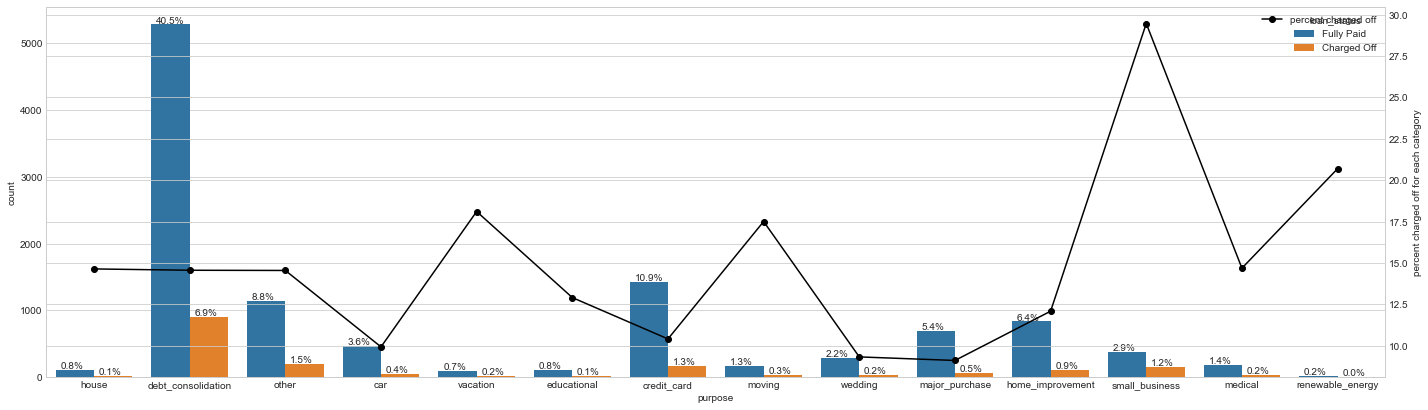

In [85]:
loan_A =loan_df[loan_df['abc']=='A']
cat_analysis("purpose","loan_status",loan_A)

The highest number of loans are taken for credit_card, but here also the chances of charged are high for small_business 

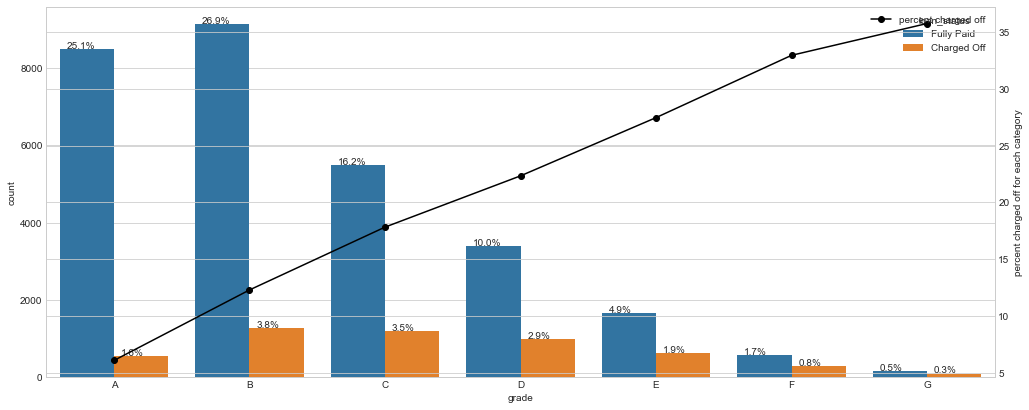

In [92]:
cat_analysis("grade","loan_status",loan_ABC)

Same kind of trend and frequency is observed for loan_A and entire loan_df

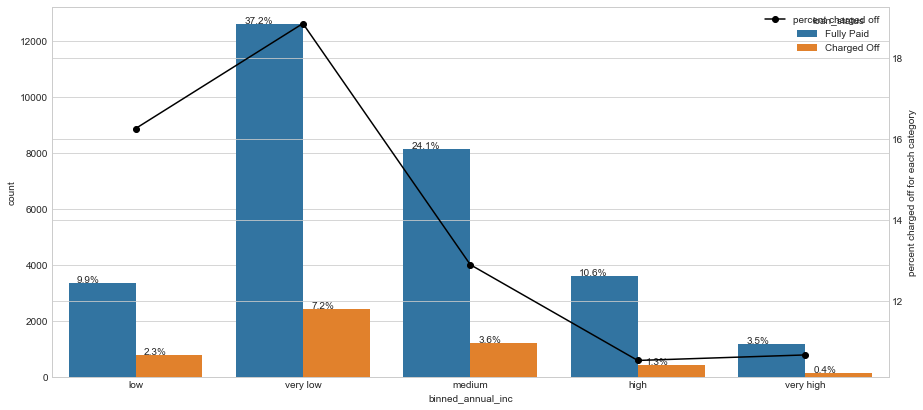

In [93]:
cat_analysis("binned_annual_inc","loan_status",loan_ABC)

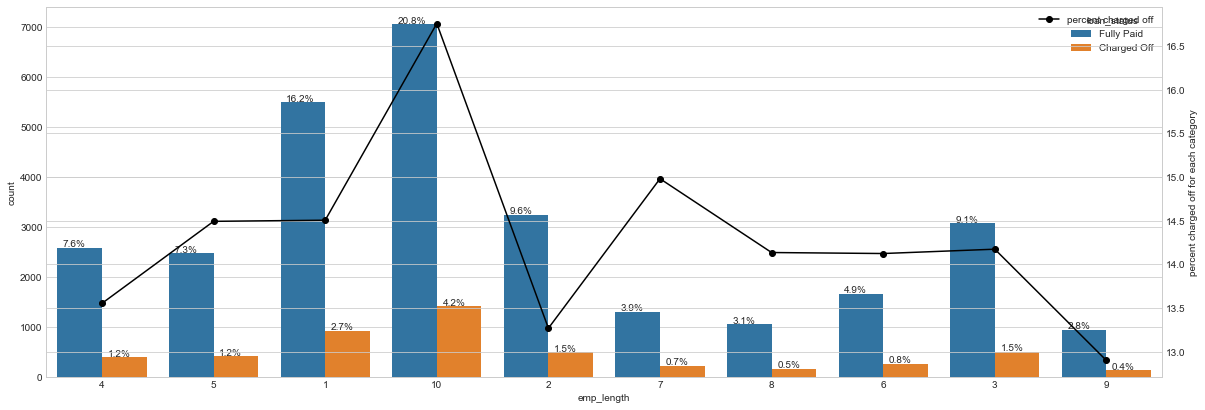

In [95]:

cat_analysis("emp_length","loan_status",loan_ABC)

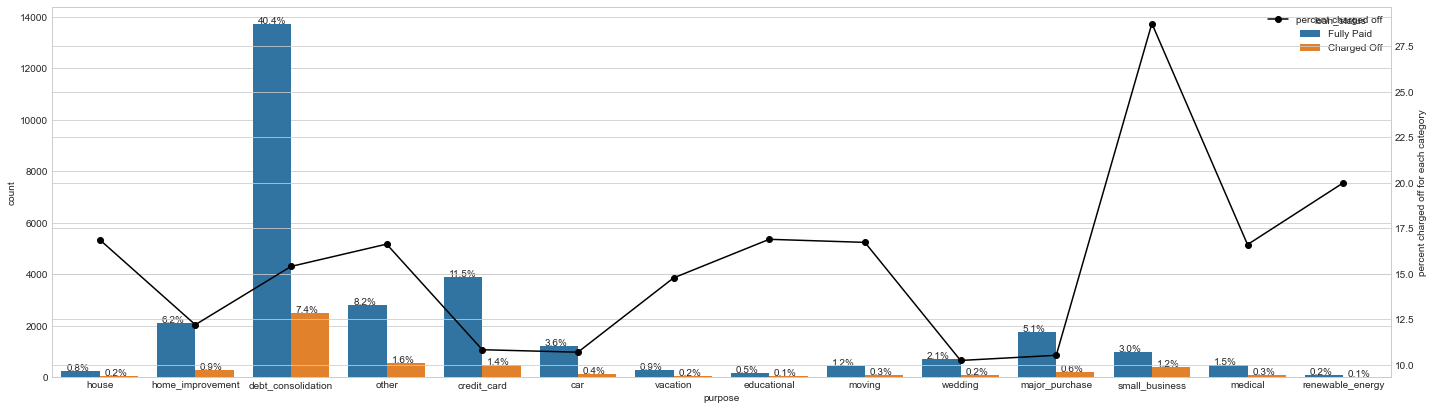

In [89]:
loan_ABC =loan_df[loan_df['abc'].isin(['A','B','C'])]
cat_analysis("purpose","loan_status",loan_ABC)

If we consider the top loan that contribute to 80% of the loan amount, we can infer that most of the loans were taken for debt_consolidation and most of them were fully paid, so the company can continue approving loan for such categories, but on the other hand the chances of charged off are again high for small_business.
In all the analysis, small_business have been the most probable reason for charged off and therefore should be taken care in future.

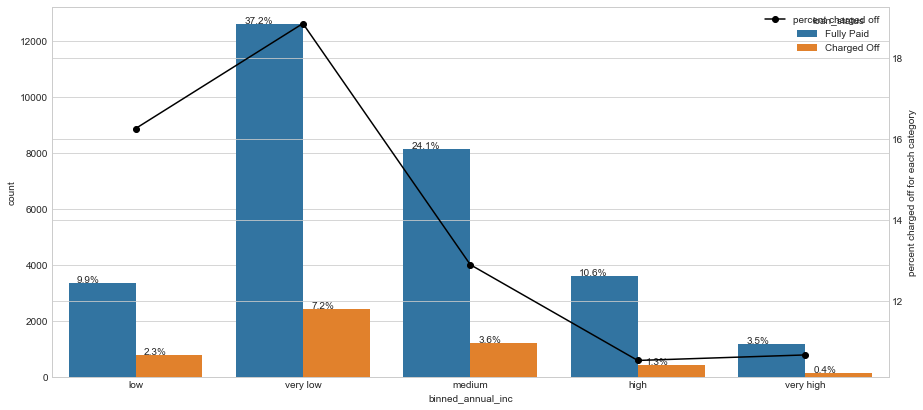

In [91]:
cat_analysis("binned_annual_inc","loan_status",loan_ABC)

Again chances of a loan being charged off are high for people taking high loan amount

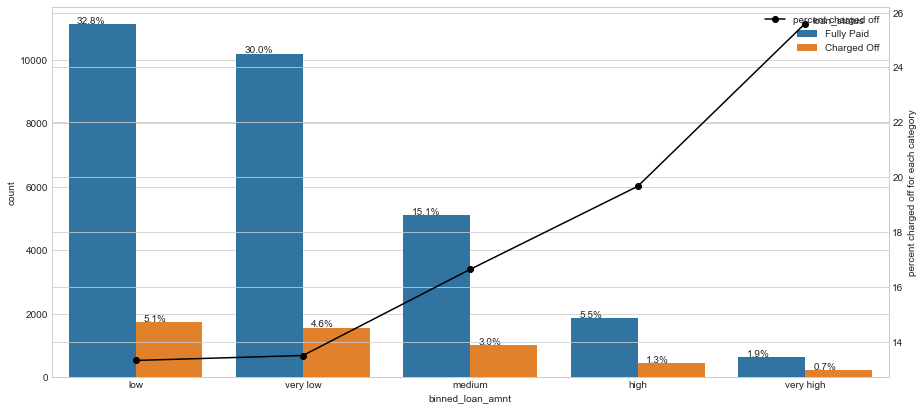

In [94]:
cat_analysis("binned_loan_amnt","loan_status",loan_ABC)

<ipython-input-71-6c64ae3900cd>:16: RuntimeWarning: overflow encountered in long_scalars
  ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float((df_cat['loan_amnt'].sum()))), (p.get_x()+0.05, p.get_height()+20))


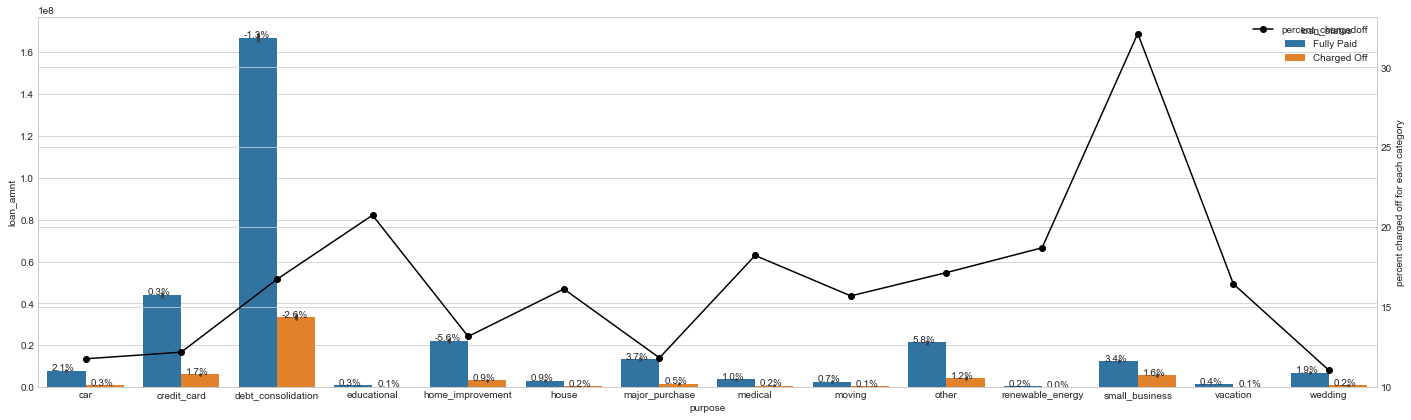

In [97]:
cat_bivariate("purpose","loan_amnt", "loan_status",loan_ABC)

<ipython-input-71-6c64ae3900cd>:16: RuntimeWarning: overflow encountered in long_scalars
  ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float((df_cat['loan_amnt'].sum()))), (p.get_x()+0.05, p.get_height()+20))


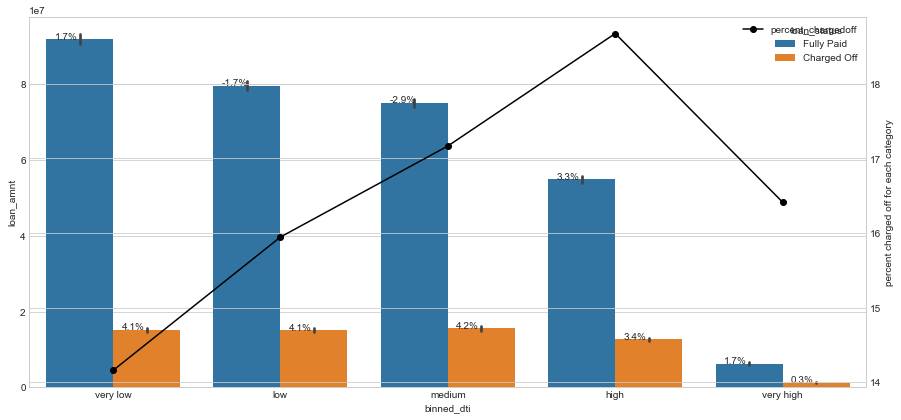

In [103]:
cat_bivariate("binned_dti","loan_amnt", "loan_status",loan_ABC)

<ipython-input-71-6c64ae3900cd>:16: RuntimeWarning: overflow encountered in long_scalars
  ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float((df_cat['loan_amnt'].sum()))), (p.get_x()+0.05, p.get_height()+20))


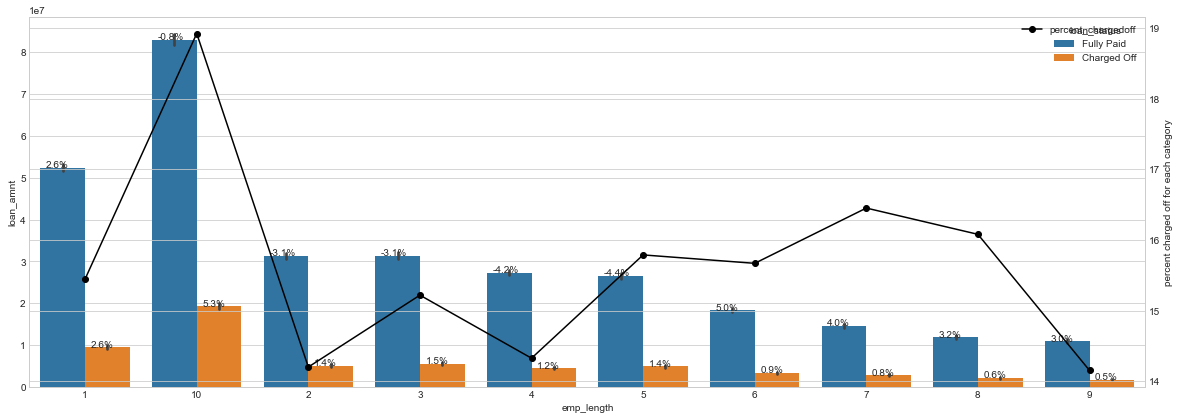

In [101]:
cat_bivariate("emp_length","loan_amnt", "loan_status",loan_ABC)

<ipython-input-71-6c64ae3900cd>:16: RuntimeWarning: overflow encountered in long_scalars
  ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float((df_cat['loan_amnt'].sum()))), (p.get_x()+0.05, p.get_height()+20))


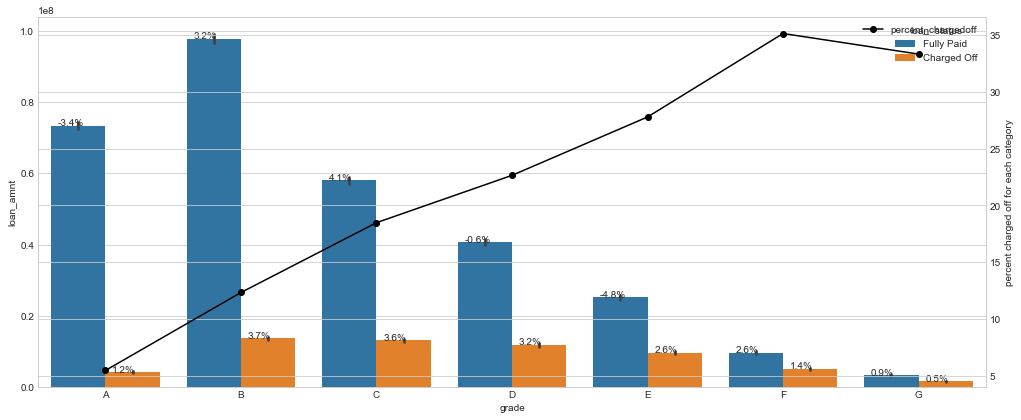

In [102]:
cat_bivariate("grade","loan_amnt", "loan_status",loan_ABC)